In [1]:
# install StellarGraph if running on Google Colab
import sys

In [2]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import numpy as np
import pandas as pd
import json
import random
from networkx.readwrite import json_graph


import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph
from stellargraph.datasets import IAEnronEmployees

%matplotlib inline

# Load DataSet 2015

In [4]:
edges_train = pd.read_csv("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/train/edges.csv")
with open("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/train/Graph.json") as json_data:
  graph_train_nx = json_graph.node_link_graph(json.load(json_data))

edges_test = pd.read_csv("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/test/edges.csv")
with open("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/test/Graph.json") as json_data:
  graph_test_nx = json_graph.node_link_graph(json.load(json_data))

print(
    f"Number of edges in training graph: {len(graph_train_nx.edges())}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test graph: {len(graph_test_nx.edges())}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in training graph: 778644
Number of edges in training set: 778644
Number of edges in test graph: 1312283
Number of edges in test set: 1312283


## Create a StellarGraph

In [5]:
graph_train_Stella = StellarGraph.from_networkx(graph_train_nx)
graph_test_Stella = StellarGraph.from_networkx(graph_test_nx)

In [6]:
graph_train = StellarGraph(
    nodes=pd.DataFrame(index=graph_train_Stella.nodes()),
    edges=edges_train,
    edge_weight_column="time",
)

graph_test = StellarGraph(
    nodes=pd.DataFrame(index=graph_test_Stella.nodes()),
    edges=edges_test,
    edge_weight_column="time",
)

## Create Link Examples

### Upload Labels

In [7]:
edges_train_pos = pd.read_csv("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/train/edges_train_label.csv")
edges_test_pos = pd.read_csv("/home/c6/Desktop/OpenWPM/jsons/CTDNE/2015/test/edges_train_label.csv")

In [8]:
def positive_and_negative_links(g, edges):
    pos = list(edges[["source", "target"]].itertuples(index=False))
    neg = sample_negative_examples(g, pos)
    return pos, neg


def sample_negative_examples(g, positive_examples):
    positive_set = set(positive_examples)

    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
            src != tgt
            and
            # neither direction of the edge should be a positive one
            (src, tgt) not in positive_set
            and (tgt, src) not in positive_set
        )

    possible_neg_edges = [
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if valid_neg_edge(src, tgt)
    ]
    return random.sample(possible_neg_edges, k=len(positive_examples))


pos, neg = positive_and_negative_links(graph_train, edges_train_pos)
pos_test, neg_test = positive_and_negative_links(graph_test, edges_test_pos)

#### View Taining graph and positive and negative links

In [9]:
print(
    f"{graph_train.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
)

StellarGraph: Undirected multigraph
 Nodes: 1460, Edges: 778644

 Node types:
  default: [1460]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [778644]
        Weights: range=[2010, 2013], mean=2011.95, std=1.03781
        Features: none
Training examples: 533639 positive links, 533639 negative links



#### View Test graph and positive and negative links

In [10]:
print(
    f"{graph_test.info()}\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 1908, Edges: 1312283

 Node types:
  default: [1908]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [1312283]
        Weights: range=[2010, 2014], mean=2012.78, std=1.28745
        Features: none
Test examples: 709355 positive links, 709355 negative links


## Running Random Walks

Define the random walk parameters we'd like to use:

    * num_walks_per_node - Number of random walks to perform per starting node.
    * walk_length - Length of each random walk. For temporal walks, this is the maximum length of a walk, since         walks may end up being shorter when there are not enough time respecting edges to traverse.
    * context_window_size - Size of the context window used to train the Word2Vec model.


In [11]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 2

In [12]:
num_cw = len(graph_train.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [13]:
from stellargraph.data import TemporalRandomWalk

temporal_rw = TemporalRandomWalk(graph_train)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 619171


In [14]:
from gensim.models import Word2Vec

embedding_size = 128
# a trained model based on our graph which can produce embeddings
temporal_model = Word2Vec(
    temporal_walks,
    size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    iter=1,
)

For convenience, we can use the trained Word2Vec models to define helper functions that transform a node ID into a node embedding.

NOTE: Temporal walks may not generate an embedding for every node in the graph; if there's no temporal walks that involve a particular node or they are all too short, the node won't appear in any context window. We handle this by using zeros as embeddings for such nodes to indicate that they are uninformative.

In [15]:
unseen_node_embedding = np.zeros(embedding_size)

def temporal_embedding(u):
    try:
        return temporal_model.wv[u]
    except KeyError:
        return unseen_node_embedding

## Node Embedding Visualisation

For visualisation of embeddings, we'll first define a helper function that we can also use later to show the TSNE visualisation.

In [16]:
def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    alpha = 0.7 if y is None else 0.5

    scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
    if y is not None:
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

We can visualise the node embeddings to take a glance at how the temporal walks have resulted in groups of nodes being clustered together

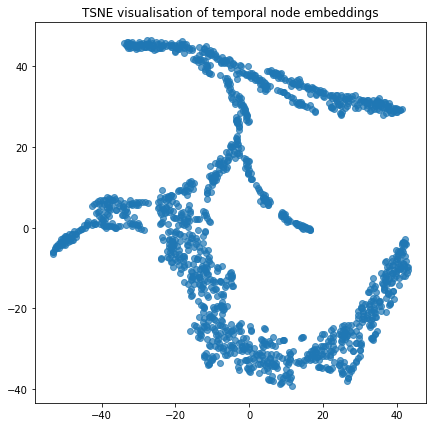

In [17]:
temporal_node_embeddings = temporal_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)

In [18]:
temporal_model.wv.vectors[1]

array([ 1.35882705e-01,  8.10017362e-02,  1.52626455e-01,  6.55804127e-02,
       -1.10187799e-01,  4.93788719e-02, -1.65707499e-01, -3.00352842e-01,
        1.18466929e-01,  8.20319820e-03, -5.42723900e-03,  6.42181858e-02,
       -4.23446447e-02,  3.43130343e-03, -4.19597141e-02,  4.09745984e-03,
       -4.22235541e-02,  3.92513014e-02,  7.91466907e-02, -1.55434787e-01,
       -1.17663309e-01, -7.18682259e-02, -2.41580084e-02, -7.92798772e-02,
        6.78589626e-04,  4.76255715e-02,  7.52150360e-03, -1.52929395e-01,
       -1.45034954e-01,  4.07259613e-02, -4.50514294e-02, -1.41769662e-01,
        6.88199326e-02,  2.01440468e-01,  6.18512072e-02, -5.66561846e-03,
        8.65977332e-02,  1.26378369e-02,  2.94379424e-02,  1.37594134e-01,
        8.35283622e-02, -1.62563249e-01, -1.40326306e-01,  4.41845730e-02,
       -1.52234972e-01, -2.74661213e-01, -2.77534097e-01,  1.88116193e-01,
       -2.11315349e-01, -2.20103294e-01, -2.05921322e-01,  5.83033897e-02,
        2.03396633e-01, -

## Link Prediction using Node Embeddings

The node embeddings we've generated can now be used as input for a link prediction task.

Below are a set of helper functions we can use to train and evaluate a link prediction classifier. The rest of the notebook will use the binary operator defined in the cell below.

Other commonly used binary operators are hadamard, average, and L1 operators. Alternatively, other user defined function taking two node embeddings to produce a link embedding could be used, but may affect convergence of the classifier model.

In [19]:
# taking two node embeddings to produce a link embedding (concatenate them using L2 operator)
def operator_l2(u, v):
    return (u - v) ** 2


binary_operator = operator_l2

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def link_examples_to_features(link_examples, transform_node):
    op_func = (
        operator_func[binary_operator]
        if isinstance(binary_operator, str)
        else binary_operator
    )
    return [
        op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_classifier(max_iter=2000):
    # Cs describes the inverse of regularization strength
    # cv number of cross folds
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    # steps List of (name, transform) tuples (implementing fit/transform) that are chained, in the order in which they are chained, with the last object an estimator.
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We'll create some positive and negative examples to train our classifier on. The negative examples can be randomly generated from the available nodes in the graph.

In [21]:
def labelled_links(positive_examples, negative_examples):
    return (
        positive_examples + negative_examples,
        np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
    )


link_examples, link_labels = labelled_links(pos, neg)
link_examples_test, link_labels_test = labelled_links(pos_test, neg_test)

## Link prediction classifier using temporal embeddings

In [ ]:
 # reture a pipeline, The pipeline can be used as any other estimator and avoids leaking the test set into the train set
temporal_clf = link_prediction_classifier()

# convert all node Ids in training dataset to embeddings
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)

# convert all node Ids in test dataset to embeddings
temporal_link_features_test = link_examples_to_features(link_examples_test, temporal_embedding)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")